In [50]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [37]:
sns.set_style('darkgrid')
%matplotlib inline

In [16]:
prices_df = pd.read_csv('train.csv')

In [17]:
input_cols, target_col = prices_df.columns[1:-1], prices_df.columns[-1]
inputs_df, targets = prices_df[input_cols].copy(), prices_df[target_col].copy()

In [18]:
numeric_cols = prices_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = prices_df[input_cols].select_dtypes(include='object').columns.tolist()

In [19]:
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [25]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

In [29]:
tree = DecisionTreeRegressor()
tree.fit(train_inputs, train_targets)

DecisionTreeRegressor()

In [31]:
tree_train_preds = tree.predict(train_inputs)

In [33]:
tree_train_rmse = mean_squared_error(tree_train_preds, train_targets)
tree_train_rmse

0.0

In [34]:
tree_val_preds = tree.predict(val_inputs)

In [35]:
tree_val_rmse = mean_squared_error(tree_val_preds, val_targets)
tree_val_rmse

1452354699.0630138

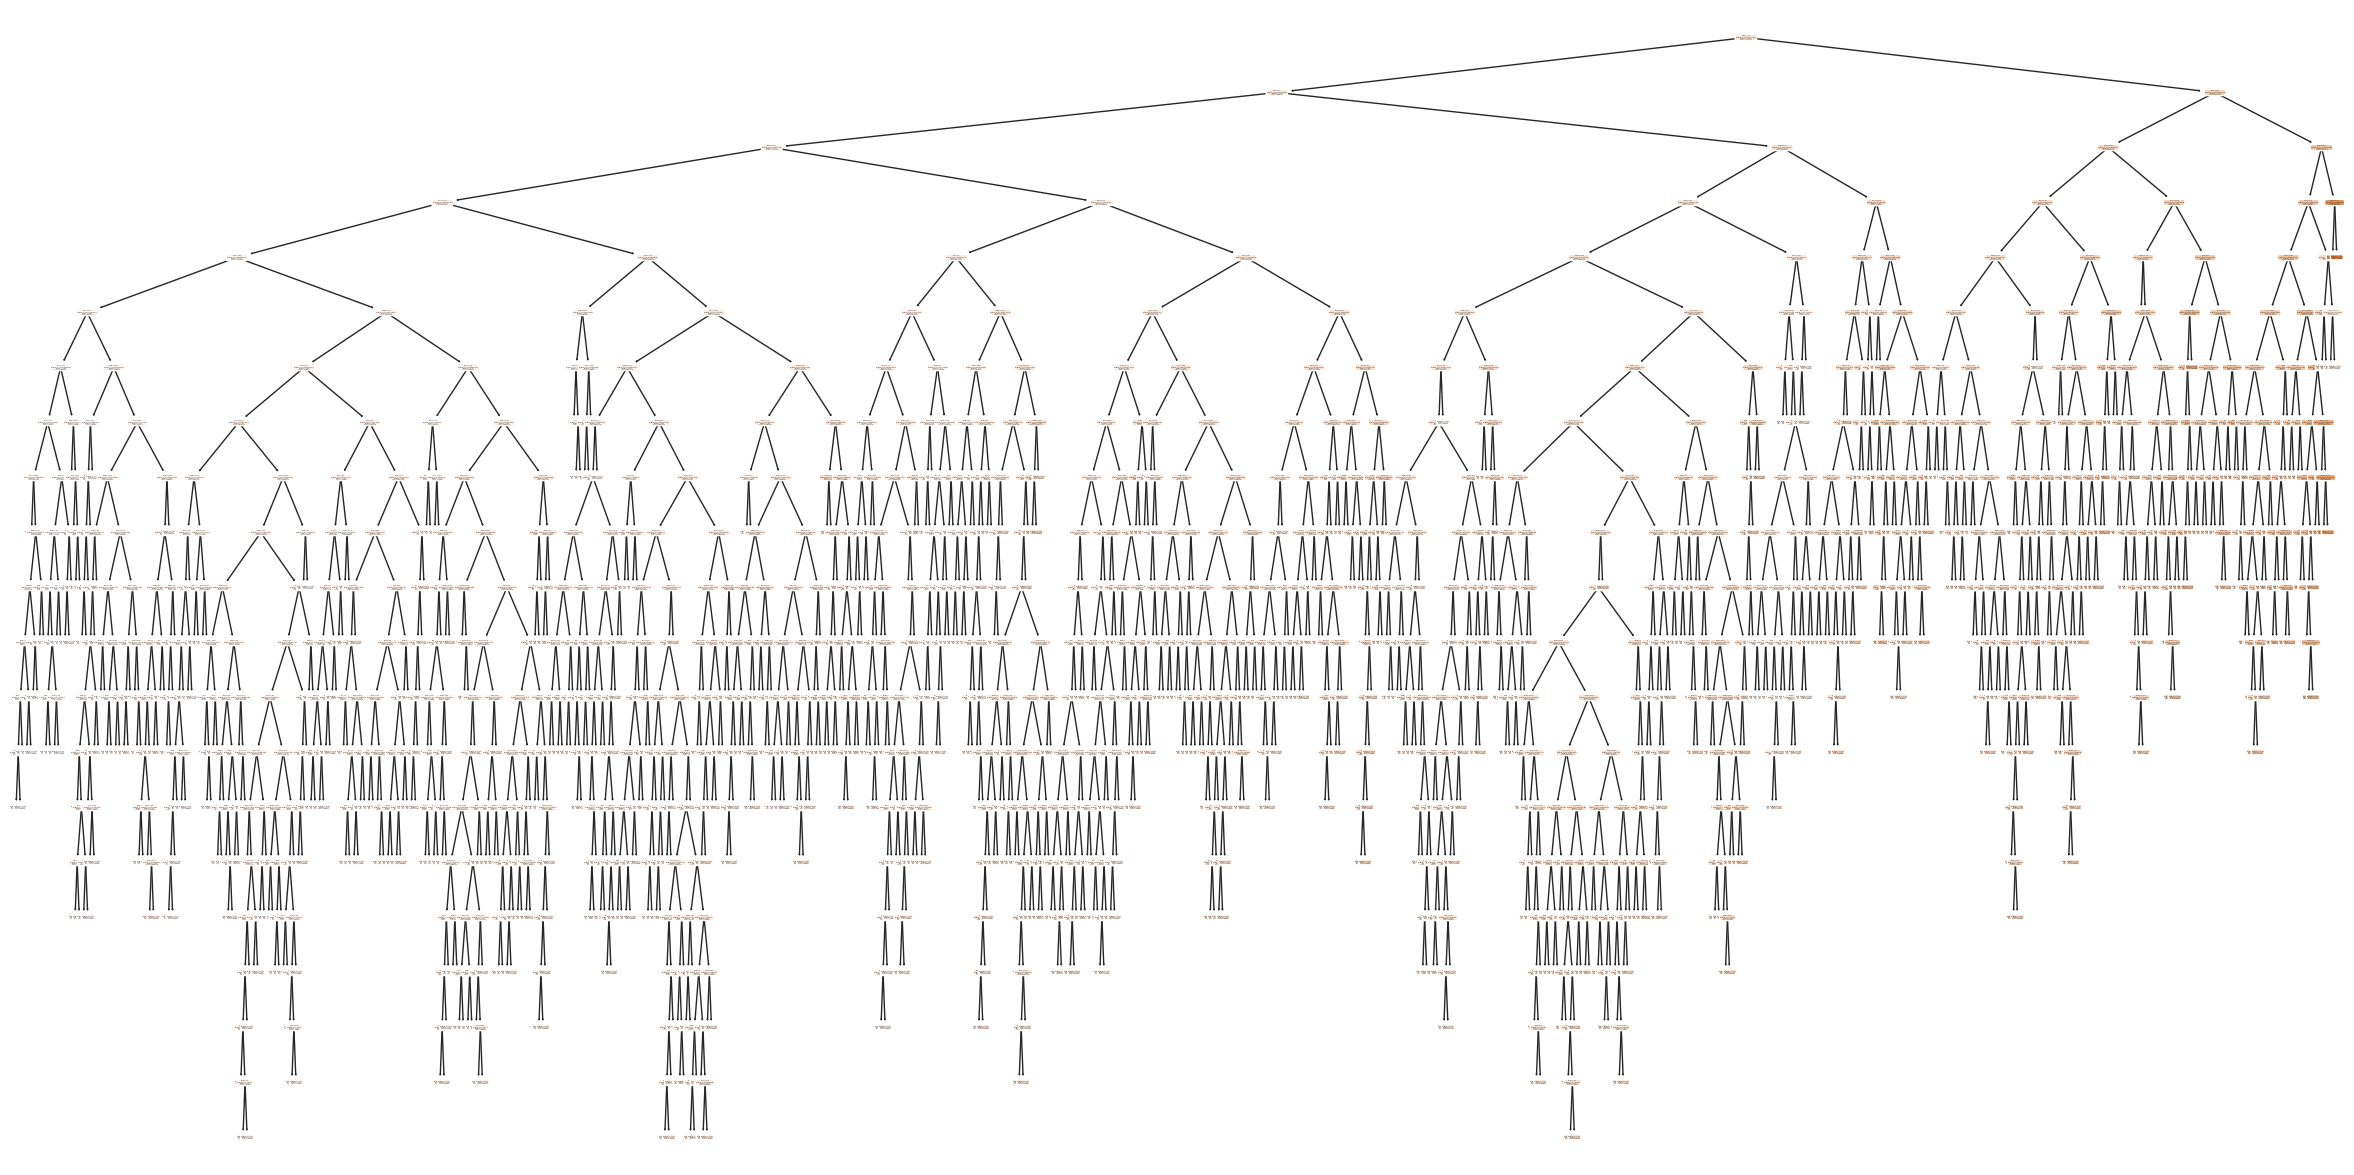

In [44]:
plt.figure(figsize=(30,15))
plot_tree(tree,
          rounded=True, # Rounded node edges
          filled=True, # Adds color according to class
          proportion=True);

In [46]:
tree_importances = tree.feature_importances_

In [47]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [48]:
tree_importance_df

,feature,importance
3,OverallQual,0.632449
15,GrLivArea,0.105020
13,2ndFlrSF,0.031679
12,1stFlrSF,0.028183
11,TotalBsmtSF,0.027282
...,...,...
216,Heating_Grav,0.000000
215,Heating_GasW,0.000000
214,Heating_GasA,0.000000
213,Heating_Floor,0.000000


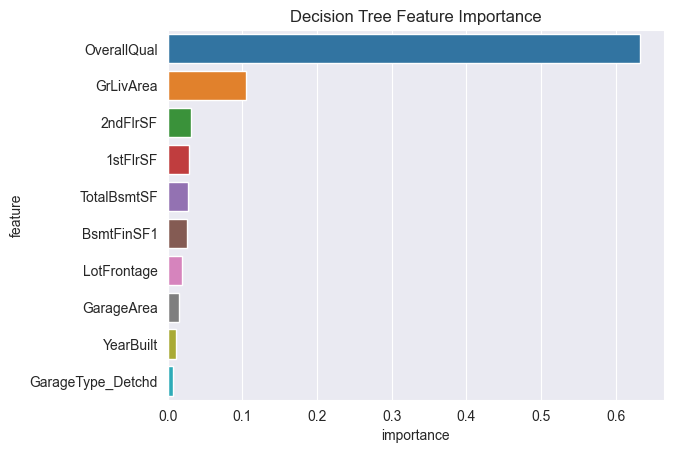

In [49]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

In [186]:
rf1 = RandomForestRegressor()

In [187]:
rf1.fit(train_inputs, train_targets)

RandomForestRegressor()

In [188]:
rf1_train_preds = rf1.predict(train_inputs)

In [189]:
rf1_train_rmse = mean_squared_error(rf1_train_preds, train_targets, squared=False)
rf1_train_rmse

12522.559480857364

In [190]:
rf1_val_preds = rf1.predict(val_inputs)

In [191]:
rf1_val_rmse = mean_squared_error(rf1_val_preds, val_targets, squared=False)
rf1_val_rmse

27246.47843621262

In [192]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 12522.559480857364, Validation RMSE: 27246.47843621262


In [62]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [63]:
test_params(n_estimators=20, max_depth=20)

(13776.89957127333, 28886.033523273858)

In [64]:
test_params(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)

(20490.359632429263, 29804.931642791606)

In [65]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

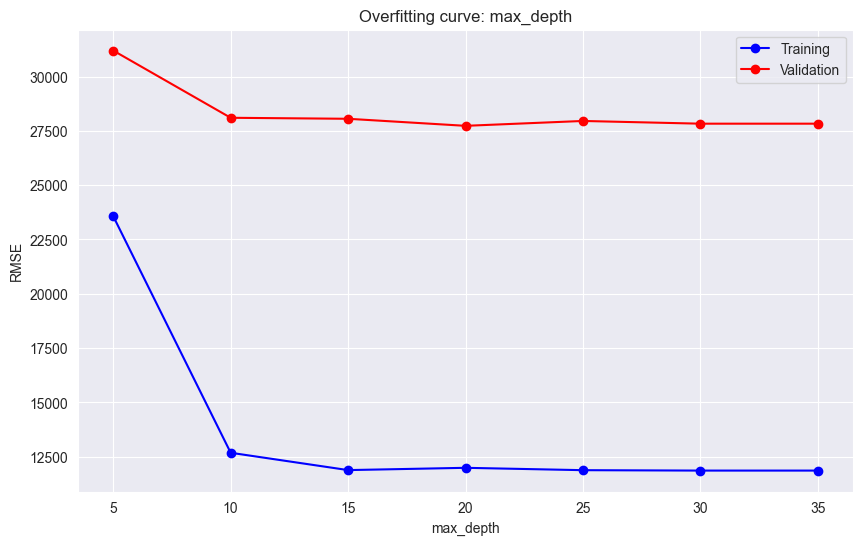

In [81]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])
#20

In [74]:
test_params(n_estimators=35, max_depth=20)

(12537.158508071654, 28221.67536123791)

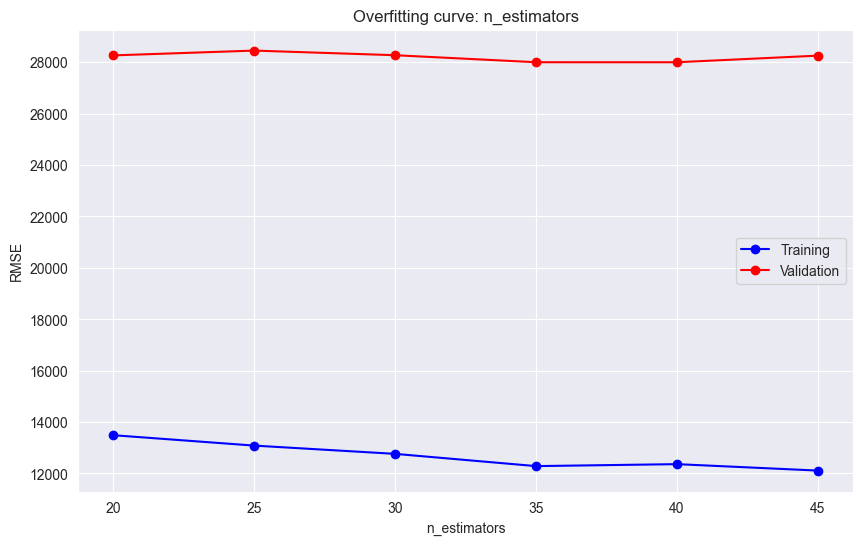

In [75]:
test_param_and_plot('n_estimators', [20, 25, 30, 35, 40, 45])
# 35

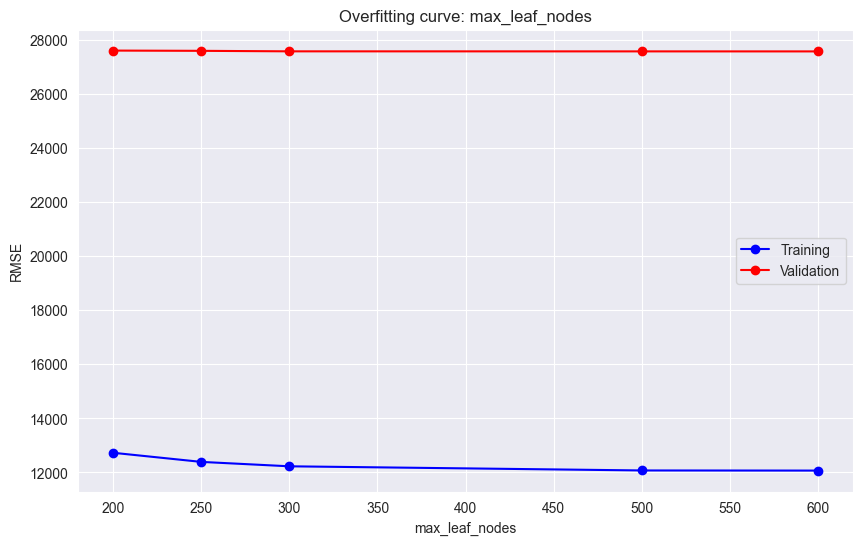

In [162]:
test_param_and_plot('max_leaf_nodes', [200, 250, 300, 500, 600])
# 65

In [290]:
rf2 = RandomForestRegressor(max_depth=25, n_estimators=35, max_leaf_nodes=300, max_features=0.5, random_state=3)

In [299]:
test_params(max_depth=25, n_estimators=35, max_leaf_nodes=300, max_features=0.5)

(12062.511592897858, 27185.878017168554)

In [240]:
test_params()

(11864.318299877767, 27830.03863639856)

In [294]:
rf2.fit(train_inputs, train_targets)

RandomForestRegressor(max_depth=25, max_features=0.5, max_leaf_nodes=300,
                      n_estimators=35, random_state=3)

In [309]:
rf2_train_preds = rf2.predict(train_inputs)
rf2_train_rmse = mean_squared_error(rf2_train_preds, train_targets, squared=False)
rf2_val_preds = rf2.predict(val_inputs)
rf2_val_rmse = mean_squared_error(rf2_val_preds, val_targets, squared=False)

In [296]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 13564.79094239374, Validation RMSE: 26288.903300113543


In [300]:
from sklearn.metrics import mean_squared_log_error

In [302]:
rf2_train_preds = rf2.predict(train_inputs)
rf2_train_rmsle = mean_squared_log_error(rf2_train_preds, train_targets, squared=False)
rf2_val_preds = rf2.predict(val_inputs)
rf2_val_rmsle = mean_squared_log_error(rf2_val_preds, val_targets, squared=False)

In [304]:
print('Train RMSE: {}, Validation RMSLE: {}'.format(rf2_train_rmsle, rf2_val_rmsle))

Train RMSE: 0.06922405559887468, Validation RMSLE: 0.14355313926528565


In [307]:
from sklearn.metrics import accuracy_score

In [312]:
rf2.score(train_inputs, train_targets)

0.9696936150534949

In [313]:
rf2.score(val_inputs, val_targets)

0.9013453322959484

In [320]:
dummy= np.full(len(val_targets), train_targets.mean())

In [321]:
mean_squared_error(dummy, val_targets, squared=False)

83757.52054897288

In [322]:
mean_squared_error(rf2_val_preds, val_targets, squared=False)

26288.903300113543